In [1]:
#Observations
#With the pandemic, 
#1. Long-term unemployment (people who are out of work 27 weeks or longer as a percent of total unemployed) 
#   has increased 8-fold.
#2. The Hispanic/Latino community had the highest unemployment at the onset of the pandemic, but has seen the
#   most dramatic improvement since.
#3. The African-American group continues to be the most impacted by the pandemic.
#4. It should come as no surprise that unemployment, during periods where there is an extraneous shock to the system 
#   such as the pandemic, is reflected as an outlier.  
#   The question is whether the outlier sets the new boundaries over time.

In [2]:
#load modules
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import json 
import requests
from config import api_key


In [3]:
#BLS url
endpoint = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

#timeseries of monthly unemployment data to query
series = ['LNS14000000','LNS14000006','LNS14000009','LNS14032183','LNS14000003','LNS13025703'] 
startyear = '2018'
endyear = '2020'


#setup json request
headers = {'Content-type': 'application/json'}
data = json.dumps(
    {"seriesid": series,
     "registrationkey": api_key,
     "startyear":startyear, 
     "endyear":endyear})

stat = requests.post(endpoint, data=data, headers=headers)
stat_data = json.loads(stat.text)
#stat = requests.post(endpoint, data=data, headers=headers)


#setup lists to hold stats
seriesid = []
year= []
period = []
periodName = []
value = []

for series in stat_data['Results']['series']:
    seriesId = series['seriesID']
    for data in series['data']:
        year.append(data['year'])
        period.append(data['period'])
        periodName.append(data['periodName'])
        value.append(data['value'])
        seriesid.append(series['seriesID'])
 

In [4]:
#create dataframe
unemployment_df = pd.DataFrame({
    "Series":seriesid,
    "Year": year,
    "Month Code": period,
    "Month": periodName,
    "Unemployment Rate": value
})

unemployment_df.head()

,Series,Year,Month Code,Month,Unemployment Rate
0,LNS14000000,2020,M10,October,6.9
1,LNS14000000,2020,M09,September,7.9
2,LNS14000000,2020,M08,August,8.4
3,LNS14000000,2020,M07,July,10.2
4,LNS14000000,2020,M06,June,11.1


In [5]:
#Add combined Mth and Year column
unemployment_df['Mth/Year'] = pd.to_datetime(unemployment_df['Month'].astype(str)+unemployment_df['Year'], format='%B%Y')

#convert Unemployment Rate to numeric to get max and min
unemployment_df['Unemployment Rate'] = pd.to_numeric(unemployment_df['Unemployment Rate'])

#sort values
unemployment_df = unemployment_df.sort_values(by=['Series','Mth/Year'], ascending=[True,True], inplace=False, ignore_index=True)

#verify sort and check min, max
unemployment_df.head(), unemployment_df['Unemployment Rate'].min(), unemployment_df['Unemployment Rate'].max()

(        Series  Year Month Code     Month  Unemployment Rate   Mth/Year
 0  LNS13025703  2018        M01   January               21.9 2018-01-01
 1  LNS13025703  2018        M02  February               21.2 2018-02-01
 2  LNS13025703  2018        M03     March               20.6 2018-03-01
 3  LNS13025703  2018        M04     April               20.4 2018-04-01
 4  LNS13025703  2018        M05       May               19.4 2018-05-01,
 2.1,
 32.5)

In [6]:
#drop Month and Year
unemployment_df = unemployment_df[['Series', 'Month Code', 'Unemployment Rate', 'Mth/Year']]

unemployment_df.head()

,Series,Month Code,Unemployment Rate,Mth/Year
0,LNS13025703,M01,21.9,2018-01-01
1,LNS13025703,M02,21.2,2018-02-01
2,LNS13025703,M03,20.6,2018-03-01
3,LNS13025703,M04,20.4,2018-04-01
4,LNS13025703,M05,19.4,2018-05-01


In [7]:
#series description
#'LNS14000000' is 'Unemployment Rate'
#'LNS14000006' is 'Unemployment-AfricanAmerican'
#'LNS14000009' is 'Unemployment-Hispanic'
#'LNS14032183' is 'Unemployment-Asian'
#'LNS14000003' is 'Unemployment-White'
#'LNS13025703' is 'Long-Term Unemployment Rate'

In [8]:
#Isolating the unemployment rate
unerate = unemployment_df.loc[unemployment_df['Series'] == 'LNS14000000',:]
uneafam = unemployment_df.loc[unemployment_df['Series'] == 'LNS14000006',:]
unehisp = unemployment_df.loc[unemployment_df['Series'] == 'LNS14000009',:]
uneasian = unemployment_df.loc[unemployment_df['Series'] =='LNS14032183',:]
unewhite = unemployment_df.loc[unemployment_df['Series'] =='LNS14000003',:]
ltunemp = unemployment_df.loc[unemployment_df['Series'] == 'LNS13025703',:]


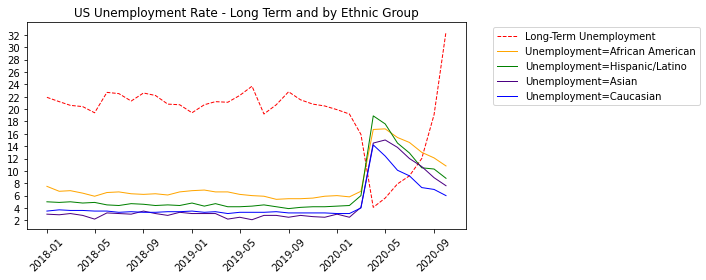

In [16]:
#line graph of x and y axis
plt.figure(figsize=(10,4))

#setting x axis 
years = ltunemp['Mth/Year']

#setting y axis 
total, = plt.plot(years, ltunemp['Unemployment Rate'], color='red', label = 'Long-Term Unemployment',linewidth =1, linestyle = '--') 
afam, = plt.plot(years, uneafam['Unemployment Rate'], color= 'orange', label = "Unemployment=African American", linewidth=1) 
hisp, = plt.plot(years, unehisp['Unemployment Rate'], color= 'green', label = "Unemployment=Hispanic/Latino", linewidth=1) 
asian, = plt.plot(years, uneasian['Unemployment Rate'], color= 'indigo', label = "Unemployment=Asian", linewidth=1) 
white, = plt.plot(years, unewhite['Unemployment Rate'], color= 'blue', label = "Unemployment=Caucasian", linewidth=1)

#setting properties 
plt.yticks(np.arange(round(unemployment_df['Unemployment Rate'].min()), 
                     round(unemployment_df['Unemployment Rate'].max()) +1, 2.0))  
plt.xticks(rotation=45)
plt.title("US Unemployment Rate - Long Term and by Ethnic Group")  

#set legend outside of box 
plt.legend(bbox_to_anchor=(1.05, 1),handles=[total, afam, hisp, asian, white])
 
plt.tight_layout() 
plt.show()

In [10]:
# Calculate the IQR and quantitatively determine if there are any potential outliers. 
# Determine outliers using upper and lower bounds

#LT unemployment
ltrate = pd.Series(ltunemp['Unemployment Rate'])

#IQR
ltquartiles = ltrate.quantile([0.25,0.5,0.75])
ltlowerq = ltquartiles[0.25]
ltupperq = ltquartiles[0.75]
ltiqr = ltupperq - ltlowerq
ltlower_bound = ltlowerq - (1.5 * ltiqr)
ltupper_bound = ltupperq + (1.5 * ltiqr)

#outliers
ltoutliers = [rate for rate in ltrate if rate < ltlower_bound or rate > ltupper_bound]

len(ltoutliers)
ltoutliers_distinct = list(set(ltoutliers))
len(ltoutliers_distinct)
ltoutliers_distinct.sort()
ltoutliers_distinct  

ltoutliers_distinct

[4.1, 5.6, 7.9, 9.2, 12.0, 32.5]

In [11]:
# Calculate the IQR and quantitatively determine if there are any potential outliers. 
# Determine outliers using upper and lower bounds

#LT unemployment
afrate = pd.Series(uneafam['Unemployment Rate'])

#IQR
afquartiles = afrate.quantile([0.25,0.5,0.75])
aflowerq = afquartiles[0.25]
afupperq = afquartiles[0.75]
afiqr = afupperq - aflowerq
aflower_bound = aflowerq - (1.5 * afiqr)
afupper_bound = afupperq + (1.5 * afiqr)

#outliers
afoutliers = [rate for rate in afrate if rate < aflower_bound or rate > afupper_bound]

len(afoutliers)
afoutliers_distinct = list(set(afoutliers))
len(afoutliers_distinct)
afoutliers_distinct.sort()
afoutliers_distinct  

afoutliers_distinct

[10.8, 12.1, 13.0, 14.6, 15.4, 16.7, 16.8]

In [12]:
# Calculate the IQR and quantitatively determine if there are any potential outliers. 
# Determine outliers using upper and lower bounds

#LT unemployment
hprate = pd.Series(unehisp['Unemployment Rate'])

#IQR
hpquartiles = hprate.quantile([0.25,0.5,0.75])
hplowerq = hpquartiles[0.25]
hpupperq = hpquartiles[0.75]
hpiqr = hpupperq - hplowerq
hplower_bound = hplowerq - (1.5 * hpiqr)
hpupper_bound = hpupperq + (1.5 * hpiqr)

#outliers
hpoutliers = [rate for rate in hprate if rate < hplower_bound or rate > hpupper_bound]

len(hpoutliers)
hpoutliers_distinct = list(set(hpoutliers))
len(hpoutliers_distinct)
hpoutliers_distinct.sort()
hpoutliers_distinct  

hpoutliers_distinct

[8.8, 10.3, 10.5, 12.9, 14.5, 17.6, 18.9]

In [13]:
# Calculate the IQR and quantitatively determine if there are any potential outliers. 
# Determine outliers using upper and lower bounds

#LT unemployment
asrate = pd.Series(uneasian['Unemployment Rate'])

#IQR
asquartiles = asrate.quantile([0.25,0.5,0.75])
aslowerq = asquartiles[0.25]
asupperq = asquartiles[0.75]
asiqr = asupperq - aslowerq
aslower_bound = aslowerq - (1.5 * asiqr)
asupper_bound = asupperq + (1.5 * asiqr)

#outliers
asoutliers = [rate for rate in asrate if rate < aslower_bound or rate > asupper_bound]

len(asoutliers)
asoutliers_distinct = list(set(asoutliers))
len(asoutliers_distinct)
asoutliers_distinct.sort()
asoutliers_distinct  

asoutliers_distinct

[7.6, 8.9, 10.7, 12.0, 13.8, 14.5, 15.0]

In [14]:
# Calculate the IQR and quantitatively determine if there are any potential outliers. 
# Determine outliers using upper and lower bounds

#LT unemployment
wtrate = pd.Series(unewhite['Unemployment Rate'])

#IQR
wtquartiles = wtrate.quantile([0.25,0.5,0.75])
wtlowerq = wtquartiles[0.25]
wtupperq = wtquartiles[0.75]
wtiqr = wtupperq - wtlowerq
wtlower_bound = wtlowerq - (1.5 * wtiqr)
wtupper_bound = wtupperq + (1.5 * wtiqr)

#outliers
wtoutliers = [rate for rate in wtrate if rate < wtlower_bound or rate > wtupper_bound]

len(wtoutliers)
wtoutliers_distinct = list(set(wtoutliers))
len(wtoutliers_distinct)
wtoutliers_distinct.sort()
wtoutliers_distinct  

wtoutliers_distinct

[6.0, 7.0, 7.3, 9.2, 10.1, 12.4, 14.2]

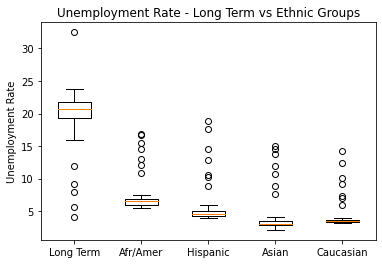

In [15]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
fig1, ax1 = plt.subplots()
ax1.set_title('Unemployment Rate - Long Term vs Ethnic Groups')
ax1.set_ylabel('Unemployment Rate')
ax1.boxplot([ltrate,afrate, hprate, asrate, wtrate], showfliers=True)
plt.xticks([1,2,3,4,5],['Long Term',"Afr/Amer", 'Hispanic','Asian','Caucasian'])
plt.show()